In [1]:
import gumpy as gp
import numpy as np
import pywt

import sklearn
import os

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import scipy
import scipy.io as sio

from scipy import linalg

import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans

#one-hot使用
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import gc

%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
sample_rate = 256 #hz
origin_channel = 16 #5 channel eeg

#采集的通道
#共16 channel
#未使用的channel使用none代替
#reference:a study on performance increasing in ssvep based bci application
SAMPLE_CHANNEL = ['Pz' , 'PO3' , 'PO4' , 'O1' , 'O2' , 'Oz' , 'O9' , 'FP2' ,
                  'C4' , 'C6' , 'CP3' , 'CP1' ,
                  'CPZ' , 'CP2' , 'CP4' , 'PO8']

LABEL2STR = {0:'person_0' , 1:'person_1' , 2:'person_2'}

# 减去前多少秒数据 second
# 减去后多少秒数据 second
CLIP_FORWARD = 2
CLIP_BACKWARD = 1

# 单个小段的实验时长
trial_time = 3 #second
trial_offset = 0 #second
start_trial_time = 0 #真正的实验开始时刻
end_trial_time = 2 #真正的实验结束时刻(<trial_time)

#是否进行归一化
#reference:a study on performance increasing in ssvep based bci application
IS_NORMALIZE = True

#是否进行滤波
IS_FILTER = True
#EEG频率范围
#reference:a study on performance increasing in ssvep based bci application
LO_FREQ = 0.5
HI_FREQ = 40

#是否陷波
IS_NOTCH = True
NOTCH_FREQ = 50 #陷波 工频



In [4]:
class EEG(gp.data.Dataset):
    def __init__(self , base_dir='none' , identifier='none' , **kwargs):
        super(EEG, self).__init__(**kwargs)
        
        self.base_dir = 'none'
        self.data_id = 'none'
        self.data_dir = 'none'
        self.data_type = 'EEG'
        self.data_name = 'EEG'
        
        
        # length of a trial (in seconds)
        self.trial_len = trial_time
        # motor imagery appears in interval (in seconds)
        self.mi_interval = [start_trial_time , end_trial_time]
        # idle perior prior to start of signal (in seconds)
        self.trial_offset = trial_offset
        # total length of a trial (in seconds)
        self.trial_total = self.trial_len
        # sampling frequency (in Hz)
        self.sampling_freq = sample_rate #gtec为256
    
    def _sep(self , data , label):
        train_data = []
        train_labels = []

        size = self.sampling_freq * self.trial_len
        data_length = data.shape[0]

        idx = 0
        
        while idx<data_length-size:
            train_data.append(data[idx : idx+size , :])
            train_labels.append(label)

            #no overlap
            idx = idx + size
        
        return np.array(train_data) , np.array(train_labels)
    
    def _butter_worth(self , data):
        b,a = scipy.signal.butter(4 , [LO_FREQ / sample_rate , HI_FREQ / sample_rate] , btype='bandpass')
    
        return np.array([scipy.signal.filtfilt(b , a , data[: , i]) for i in range(data.shape[1])]).reshape((-1 , origin_channel))
    
    def _notch(self , data):
        cutoff = NOTCH_FREQ #50
        Q = 30

        nyq = 0.5 * sample_rate
        w0 = cutoff / nyq

        b , a = scipy.signal.iirnotch(w0 , Q)

        return np.array([scipy.signal.filtfilt(b , a , data[: , i]) for i in range(data.shape[1])]).reshape((-1 , origin_channel))
    
    def _normalize(self , data):
        mean = np.mean(data, axis=0)
        std_dev = np.std(data, axis=0)
        
        return (data - mean) / std_dev
    
    def _load_data(self , filename):
        data = sio.loadmat(file_name=filename)['data_received'] #length*16 matrix
        
        #此通道没有采集 置为0
        for i in range(len(SAMPLE_CHANNEL)):
            if SAMPLE_CHANNEL[i] == 'none':
                data[: , i] = 0.0
        
        #删除前x秒和后x秒数据
        data = data[CLIP_FORWARD * self.sampling_freq : - CLIP_BACKWARD * self.sampling_freq]
        
        if IS_NORMALIZE:
            data = self._normalize(data)
        
        if IS_FILTER:
            data = self._butter_worth(data)
        
        if IS_NOTCH:
            data = self._notch(data)
    
        return data
    
    def _concatenate(self , eeg_matrix):
        return np.concatenate(eeg_matrix , axis=0)
    
    def _combine(self):
        person_0_filenames = os.listdir('real_data/eeg_11.24/circle/1/10hz/')
        person_1_filenames = os.listdir('real_data/eeg_11.24/circle/2/10hz/')
        person_2_filenames = os.listdir('real_data/eeg_11.24/circle/3/10hz/')

        person_0 = [self._load_data('real_data/eeg_11.24/circle/1/10hz/' + filename) for filename in person_0_filenames]
        person_1 = [self._load_data('real_data/eeg_11.24/circle/2/10hz/' + filename) for filename in person_1_filenames]
        person_2 = [self._load_data('real_data/eeg_11.24/circle/3/10hz/' + filename) for filename in person_2_filenames]

        person_0 = self._concatenate(person_0)
        person_1 = self._concatenate(person_1)
        person_2 = self._concatenate(person_2)
       
        #数据分段
        train_person_data_0 , train_person_labels_0 = self._sep(person_0 , label = 0)
        train_person_data_1 , train_person_labels_1 = self._sep(person_1 , label = 1)
        train_person_data_2 , train_person_labels_2 = self._sep(person_2 , label = 2)

        #产生索引并置乱
        idx_train_data = list(range(len(train_person_data_0) + len(train_person_data_1)+ len(train_person_data_2)))
        
        np.random.shuffle(idx_train_data)

        #合并数据
        train_data = np.concatenate((train_person_data_0 , train_person_data_1 , train_person_data_2))
        train_labels = np.concatenate((train_person_labels_0 , train_person_labels_1 , train_person_labels_2))

        #将训练数据打乱
        train_data = train_data[idx_train_data]
        train_labels = train_labels[idx_train_data] ##self.labels
        
        #合并为sequence
        train_data_sequence = np.reshape(train_data , newshape=(-1 , origin_channel)) #length*channel

        train_data_count = train_data.shape[0]

        #trial索引
        trial_idx = np.array([i*(self.sampling_freq * self.trial_len) for i in range(train_data_count)]) ##self.trial
        
        #构建子类成员
        self.raw_data = train_data_sequence
        self.trials = trial_idx
        
        #只使用下面的成员
        self.labels = train_labels
        self.data = train_data
        
        
    def load(self, **kwargs):
        self._combine()
     

In [5]:
dataset = EEG()
dataset.load()

C:\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [6]:
print(dataset.data.shape , dataset.labels.shape)

(135, 768, 16) (135,)


In [7]:
dataset.data = np.expand_dims(dataset.data , axis=-1)

In [8]:
print(dataset.data.shape , dataset.labels.shape)

(135, 768, 16, 1) (135,)


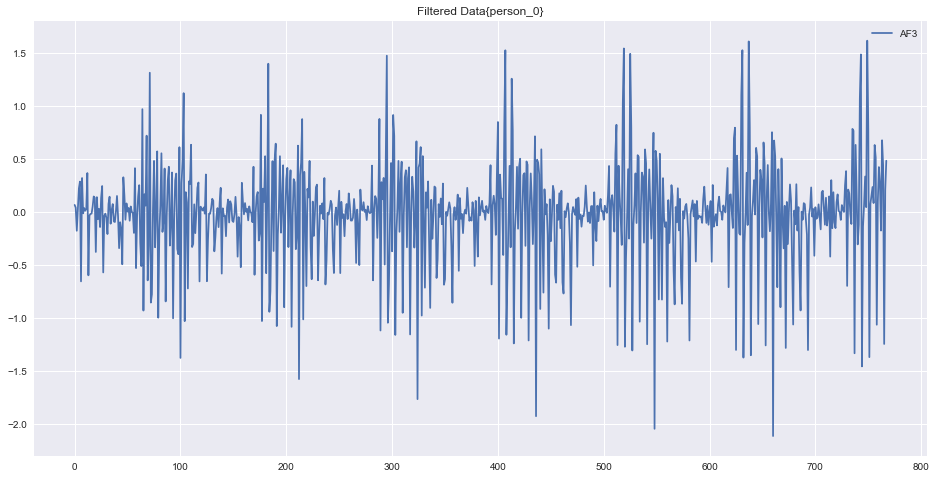

In [9]:
##查看数据信息
#一个trial的信号数据 index
display_idx = 20

plt.figure(figsize=(16,8))
plt.clf()
plt.plot(dataset.data[display_idx , 0:768 , 0 , 0], label='AF3')
plt.legend()
plt.title("Filtered Data{%s}" % LABEL2STR[dataset.labels[display_idx]])

In [10]:
from keras.models import Sequential , Model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import Flatten

from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import Reshape


from keras.optimizers import Adam

In [11]:
input_eeg = Input(shape=(sample_rate*trial_time , origin_channel , 1))
#encoder
conv1 = Conv2D(96 , kernel_size=(11 , 2) , activation='relu' , padding='valid')(input_eeg)
pooling1 = MaxPool2D(padding='valid')(conv1)

conv2 = Conv2D(96 , kernel_size=(11 , 2) , activation='relu' , padding='valid')(pooling1)
pooling2 = MaxPool2D(padding='valid')(conv2)

conv3 = Conv2D(256 , kernel_size=(11 , 2) , activation='relu' , padding='valid')(pooling2)
pooling3 = MaxPool2D(padding='valid')(conv3)

flatten = Flatten()(pooling3)

fc4 = Dense(units=512 , activation='relu')(flatten)
fc5 = Dense(units=256 , activation='relu')(fc4)
fc6 = Dense(units=8 , activation='relu')(fc5)

encoder = Model(inputs = input_eeg , outputs=fc6)

#decoder
input_decoder = encoder(input_eeg)
fc7 = Dense(units=256 , activation='relu')(input_decoder)

fc8 = Dense(units=96*2*512 , activation='relu')(fc7)

reshape = Reshape(target_shape=(96 , 2 , 512))(fc8)

up9 = UpSampling2D()(reshape)
conv9 = Conv2DTranspose(96 , kernel_size=(11,2) , activation='relu' , padding='same')(up9)

up10 = UpSampling2D()(conv9)
conv10 = Conv2DTranspose(96 , kernel_size=(11,2) , activation='relu' , padding='same')(up10)

up11 = UpSampling2D()(conv10)
conv11 = Conv2DTranspose(1 , kernel_size=(11,11) , activation='relu' , padding='same')(up11)

#autoencoder
autoencoder = Model(inputs = input_eeg , outputs = conv11)

#dnn_classifier
input_dnn = encoder(input_eeg)
fc12 = Dense(units=4 , activation='relu')(input_dnn)
fc13 = Dense(units=3 , activation='softmax')(input_dnn)

dnn_classifier = Model(inputs = input_eeg , outputs = fc13)

In [12]:
autoencoder.compile(optimizer=Adam() , loss='mse' , metrics=['accuracy'])

In [13]:
autoencoder.fit(dataset.data , dataset.data , batch_size=32 , epochs=10 , verbose = True)

Epoch 1/10
135/135 [==============================] - 5s 37ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 2/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 3/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 4/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 5/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 6/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 7/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 8/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 9/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00
Epoch 10/10
135/135 [==============================] - 1s 9ms/step - loss: 0.0935 - acc: 0.0000e+00


In [14]:
dnn_classifier.compile(optimizer=Adam() , loss='categorical_crossentropy' , metrics=['accuracy'])

In [15]:
dnn_classifier.fit(dataset.data , to_categorical(dataset.labels , num_classes=3) , batch_size=16 , epochs=10 , verbose=True ,
                   validation_split=0.3)

Train on 94 samples, validate on 41 samples
Epoch 1/10
94/94 [==============================] - 1s 12ms/step - loss: 1.0981 - acc: 0.4043 - val_loss: 1.0976 - val_acc: 0.3415
Epoch 2/10
94/94 [==============================] - 0s 4ms/step - loss: 1.0968 - acc: 0.4468 - val_loss: 1.0963 - val_acc: 0.3415
Epoch 3/10
94/94 [==============================] - 0s 4ms/step - loss: 1.0952 - acc: 0.4468 - val_loss: 1.0951 - val_acc: 0.3415
Epoch 4/10
94/94 [==============================] - 0s 4ms/step - loss: 1.0939 - acc: 0.4468 - val_loss: 1.0937 - val_acc: 0.3415
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 1.0923 - acc: 0.4468 - val_loss: 1.0926 - val_acc: 0.3415
Epoch 6/10
94/94 [==============================] - 0s 4ms/step - loss: 1.0908 - acc: 0.4468 - val_loss: 1.0914 - val_acc: 0.3415
Epoch 7/10
94/94 [==============================] - 0s 4ms/step - loss: 1.0895 - acc: 0.4468 - val_loss: 1.0901 - val_acc: 0.3415
Epoch 8/10
94/94 [===========================

In [16]:
feature = encoder.predict(dataset.data)

In [21]:
svc = SVC(verbose=True)

In [22]:
svc.fit(feature , dataset.labels)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [23]:
svc.score(feature[:] , dataset.labels[:])

0.4148148148148148

In [24]:
rf = RandomForestClassifier()

In [25]:
rf.fit(feature , dataset.labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [26]:
rf.score(feature , dataset.labels)

0.4148148148148148

# Alpha and Beta sub-bands

In [167]:
def alpha_subBP_features(data):
    alpha1 = gp.signal.butter_bandpass(data , 8.5,11.5 , order=6)
    alpha2 = gp.signal.butter_bandpass(data , 9.0,12.5 , order=6)    
    alpha3 = gp.signal.butter_bandpass(data , 9.5,11.5 , order=6)    
    alpha4 = gp.signal.butter_bandpass(data , 8.0,10.5 , order=6)   
    
    return [alpha1 , alpha2 , alpha3 , alpha4]

alpha_bands = np.array(alpha_subBP_features(dataset))

C:\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [168]:
def beta_subBP_features(data):
    beta1 = gp.signal.butter_bandpass(data , 14.0,30.0,order=6)
    beta2 = gp.signal.butter_bandpass(data , 16.0,17.0,order=6)    
    beta3 = gp.signal.butter_bandpass(data , 17.0,18.0,order=6)    
    beta4 = gp.signal.butter_bandpass(data , 18.0,19.0,order=6)    
    
    return [beta1 , beta2 , beta3 , beta4]

beta_bands = np.array(beta_subBP_features(dataset))

C:\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


## Method 1: logarithmic sub-band power

In [169]:
def powermean(data , trial , fs , w):
    #官方demo跳4秒 前4秒为准备阶段
    return np.power(data[trial + w[0] : trial+w[1] , 0] , 2).mean(), \
            np.power(data[trial + w[0] : trial+w[1] , 1] , 2).mean(), \
            np.power(data[trial + w[0] : trial+w[1] , 2] , 2).mean(), \
            np.power(data[trial + w[0] : trial+w[1] , 3] , 2).mean(), \
            np.power(data[trial + w[0] : trial+w[1] , 4] , 2).mean(), \
            np.power(data[trial + w[0] : trial+w[1] , 5] , 2).mean(), \
            np.power(data[trial + w[0] : trial+w[1] , 6] , 2).mean(), \
            np.power(data[trial + w[0] : trial+w[1] , 7] , 2).mean()

In [170]:
def log_subBP_feature_extraction(alpha , beta , trials , fs , w):
    n_features = 40
    X = np.zeros((len(trials) , n_features))
    
    for t , trial in enumerate(trials):
        # trial是一个scalar
        # t也是一个scalar
        power_1_a = powermean(alpha[0], trial, fs, w)
        power_2_a = powermean(alpha[1], trial, fs, w)
        power_3_a = powermean(alpha[2], trial, fs, w)
        power_4_a = powermean(alpha[3], trial, fs, w)
        
        power_1_b = powermean(beta[0], trial, fs, w)
        
        X[t, :] = np.array(
            [np.log(power_1_a) ,
             np.log(power_2_a) ,
             np.log(power_3_a) ,
             np.log(power_4_a) ,
             np.log(power_1_b) ]).flatten()

    return X

In [171]:
dataset.raw_data.shape

(103680, 16)

In [172]:
#将数据段拆分成两部分

w1 = [0 , (sample_rate*trial_time) // 2]
w2 = [(sample_rate*trial_time) // 2 , (sample_rate*trial_time)]

features1 = log_subBP_feature_extraction(alpha_bands , beta_bands , dataset.trials , dataset.sampling_freq , w1)
features2 = log_subBP_feature_extraction(alpha_bands , beta_bands , dataset.trials , dataset.sampling_freq , w2)

In [173]:
features = np.concatenate((features1.T , features2.T)).T

In [174]:
features -= np.mean(features)

In [175]:
features = gp.signal.normalize(features , 'min_max')

In [176]:
features.shape

(135, 80)

## Method 2: DWT
## no use

In [75]:
def dwt_features(data , trials , level , sampling_freq , w , n , wavelet):
    n_features = 24
    
    X = np.zeros((len(trials) , n_features))
    
    for t , trial in enumerate(trials):
        signals = data[trial + w[0] : trial + w[1]]
        
        coeffs_Pz  = pywt.wavedec(data = signals[:,0], wavelet=wavelet, level=level)
        coeffs_PO3 = pywt.wavedec(data = signals[:,1], wavelet=wavelet, level=level)
        coeffs_PO4 = pywt.wavedec(data = signals[:,2], wavelet=wavelet, level=level)
        coeffs_O1  = pywt.wavedec(data = signals[:,3], wavelet=wavelet, level=level)
        coeffs_O2  = pywt.wavedec(data = signals[:,4], wavelet=wavelet, level=level)
        coeffs_Oz  = pywt.wavedec(data = signals[:,5], wavelet=wavelet, level=level)
        coeffs_O9  = pywt.wavedec(data = signals[:,6], wavelet=wavelet, level=level)
        coeffs_FP2 = pywt.wavedec(data = signals[:,7], wavelet=wavelet, level=level)

        X[t, :] = np.array([
            np.std(coeffs_Pz [n]),   
            np.std(coeffs_PO3[n]),  
            np.std(coeffs_PO4[n]),   
            np.std(coeffs_O1 [n]),  
            np.std(coeffs_O2 [n]),  
            np.std(coeffs_Oz [n]),   
            np.std(coeffs_O9 [n]),  
            np.std(coeffs_FP2[n]),  
            
            np.mean(coeffs_Pz [n]**2),
            np.mean(coeffs_PO3[n]**2 ),
            np.mean(coeffs_PO4[n]**2 ),
            np.mean(coeffs_O1 [n]**2 ),
            np.mean(coeffs_O2 [n]**2),
            np.mean(coeffs_Oz [n]**2 ),
            np.mean(coeffs_O9 [n]**2 ),
            np.mean(coeffs_FP2[n]**2),
            
            np.mean(coeffs_Pz [n]),
            np.mean(coeffs_PO3[n]), 
            np.mean(coeffs_PO4[n]),
            np.mean(coeffs_O1 [n]),
            np.mean(coeffs_O2 [n]),
            np.mean(coeffs_Oz [n]),
            np.mean(coeffs_O9 [n]),
            np.mean(coeffs_FP2[n])]).flatten()
        
        return X

In [76]:
# 全trial
# 后续使用log特征
if False:
    w = [0 , sample_rate*trial_time]
    
    trials = dataset.trials
    fs = dataset.sampling_freq
    
    features1 = np.array(dwt_features(btr_data , trials , 5 , fs , w , 3 , 'db4'))
    features2 = np.array(dwt_features(btr_data , trials , 5 , fs , w , 4 , 'db4'))   
    
    features = np.concatenate((features1.T , features2.T)).T
    features -= np.mean(features)
    features_ = gp.signal.normalize(features , 'min_max')

NameError: name 'btr_data' is not defined

In [34]:
features.shape

(44, 50)

## Sequential Feature Selection

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.0s finished

[2018-11-28 16:11:38] Features: 1/12 -- score: 0.5066666666666667[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished

[2018-11-28 16:11:44] Features: 2/12 -- score: 0.5845238095238094[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished

[2018-11-28 16:11:50] Features: 3/12 -- score: 0.6316666666666666[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | el

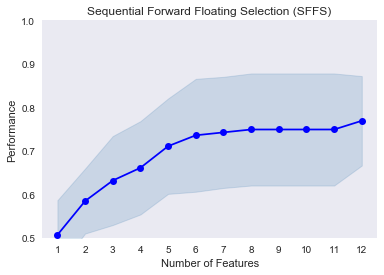

In [177]:
# Sequential Feature Selection Algorithm
#使用log 特征

feature_idx, cv_scores, algorithm , SequentialFeatureSelector , LinearDiscriminantAnalysis = gp.features.sequential_feature_selector(features, dataset.labels, 'LDA',  12 , 10, 'SFFS')

#选取6-12个特征 具体的特征个数在6-12之间
# feature_idx, cv_scores, algorithm , SequentialFeatureSelector , LinearDiscriminantAnalysis = gp.features.sequential_feature_selector(features, labels, 'LDA', (6,12) , 10, 'SFFS')

In [178]:
cv_scores

0.769047619047619

In [179]:
algorithm

'Sequential Forward Floating Selection (SFFS)'

## PCA

In [180]:
PCA = gp.features.PCA_dim_red(features , 0.95)

In [181]:
PCA.shape

(135, 2)

## training and classification

In [182]:
split_features = gp.split.shuffle_Split(features , dataset.labels , n_splits=10 , test_size=0.2 , random_state=0)

In [183]:
X_train = split_features[0]
X_test = split_features[1]

Y_train = split_features[2]
Y_test = split_features[3]

In [184]:
X_train.shape

(108, 80)

In [185]:
X_test.shape

(27, 80)

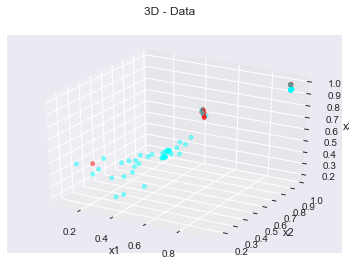

In [186]:
# PCA and plot in low-dimension

gp.plot.PCA('3D' , features , X_train , Y_train)

In [187]:
results , clf = gp.classify('LDA' , X_train , Y_train , X_test , Y_test)

In [188]:
print(results)
print(results.accuracy)

             precision    recall  f1-score   support

          0       0.40      0.67      0.50         6
          1       0.60      0.50      0.55        12
          2       0.43      0.33      0.38         9

avg / total       0.50      0.48      0.48        27

48.148148148148145


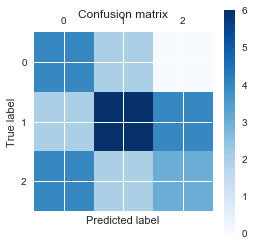

In [189]:
gp.plot.confusion_matrix(Y_test , results.pred)

In [97]:
results.pred

array([2, 3, 2, 0, 0, 2, 1, 1, 2, 3, 2])

In [98]:
results , _ = gp.classification.vote(X_train , Y_train , X_test , Y_test , 'hard' , False , (6,12))


C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [99]:
print(results)
print(results.accuracy)

             precision    recall  f1-score   support

          0       0.20      0.50      0.29         2
          1       0.00      0.00      0.00         4
          2       0.00      0.00      0.00         3
          3       0.00      0.00      0.00         2

avg / total       0.04      0.09      0.05        11

9.090909090909092


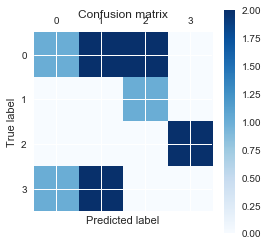

In [100]:
gp.plot.confusion_matrix(results.pred , Y_test)